In [1]:
import nb_setup 
import importlib
importlib.reload(nb_setup)
nb_setup.init()

Added project root to sys.path: /Users/falconlin/Development/trading
Changed current working directory to: /Users/falconlin/Development/trading
Initialized project with base directory: /Users/falconlin/Development/trading


In [2]:
import pandas as pd
from settings import DATA_DIR

df = pd.read_csv(DATA_DIR / "all_ranked.csv", index_col=[0])
df.head()

,start_time,average_rank,rank_rolling_accumulated_pct_change,rank_rolling_variance_pct_change,open,close
symbol,,,,,,
BTC,2024-02-10 00:00:00,NaN,NaN,NaN,47166.0,47244.0
BTC,2024-02-10 00:15:00,46.0,46.0,NaN,47244.0,47204.0
BTC,2024-02-10 00:30:00,23.0,42.0,4.0,47204.0,47147.0
BTC,2024-02-10 00:45:00,18.0,34.0,2.0,47146.0,47116.0
BTC,2024-02-10 01:00:00,13.0,24.0,2.0,47122.0,47110.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164217 entries, BTC to LDO
Data columns (total 6 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   start_time                           164217 non-null  object 
 1   average_rank                         164160 non-null  float64
 2   rank_rolling_accumulated_pct_change  164160 non-null  float64
 3   rank_rolling_variance_pct_change     164103 non-null  float64
 4   open                                 164217 non-null  float64
 5   close                                164217 non-null  float64
dtypes: float64(5), object(1)
memory usage: 8.8+ MB


In [8]:
import pandas as pd


def calculate_returns(df_final):
    # Initial principal amount
    principal = 100
    slippage_and_cost = 0.003  # 0.3% trading cost
    trading_interval = 1  # 1=15mins

    # Assuming df_final is your prepared DataFrame

    # Convert start_time to datetime if not already
    df_final["start_time"] = pd.to_datetime(df_final["start_time"])

    # Sort by start_time and average_rank to make sure we can pick top and bottom ranks easily
    df_final = df_final.sort_values(by=["start_time", "average_rank"])

    # Find unique timestamps
    timestamps = df_final["start_time"].unique()

    # Initialize a list to store the results of each interval
    results = []

    for i in range(len(timestamps) - 1):
        current_time = timestamps[i]
        next_time = timestamps[i + 1]

        # Filter the DataFrame for the current timestamp
        current_interval = df_final[df_final["start_time"] == current_time]

        # Split into top 10 and bottom 10 coins
        top_10 = current_interval.head(10).copy()
        bottom_10 = current_interval.tail(10).copy()

        # Calculate the investment per coin
        investment_per_coin = principal / 20  # Divided among top 10 and bottom 10

        # Calculate returns for the next interval
        top_10["next_open"] = top_10["open"].shift(-1)
        top_10["next_close"] = top_10["close"].shift(-1)
        bottom_10["next_open"] = bottom_10["open"].shift(-1)
        bottom_10["next_close"] = bottom_10["close"].shift(-1)

        # Long the top 10
        long_returns = (
            ((-top_10["next_open"] + top_10["next_close"]))
            * (investment_per_coin / top_10["next_open"])
            * (1 - slippage_and_cost)
        )

        # Short the bottom 10
        short_returns = (
            ((bottom_10["next_open"] - bottom_10["next_close"]))
            * (investment_per_coin / bottom_10["next_open"])
            * (1 - slippage_and_cost)
        )

        # Sum returns and update principal
        # interval_return = long_returns.sum() + short_returns.sum()
        interval_return = long_returns.sum()
        principal += interval_return

        results.append(
            {
                "timestamp": current_time,
                "return": interval_return,
                "principal": principal,
            }
        )
        print("---------------------------------------------")
        print(
            f"For interval {i}: Long {top_10.index.values}, Short {bottom_10.index.values}"
        )
        print(
            f"In interval {i}, the return is {interval_return}, new principal is {principal}"
        )

    # Convert the results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)

    # Calculate overall performance
    total_performance = results_df["return"].sum()

    print("Total simulated return over the period:", total_performance)


calculate_returns(df)

---------------------------------------------
For interval 0: Long ['BTC' 'ETH' 'SOL' 'WLD' 'WIF' 'DOGE' 'kPEPE' 'BNB' 'AVAX' 'NEAR'], Short ['GMT' 'MANTA' 'XAI' 'DYDX' 'BLUR' 'MAVIA' 'AAVE' 'LTC' 'CAKE' 'LDO']
In interval 0, the return is 0.39863739442843904, new principal is 100.39863739442843
---------------------------------------------
For interval 1: Long ['WIF' 'MINA' 'MAVIA' 'AVAX' 'ENS' 'BLUR' 'TIA' 'ALT' 'INJ' 'MATIC'], Short ['AI' 'XRP' 'GALA' 'AAVE' 'LINK' 'PYTH' 'XAI' 'DYM' 'SEI' 'STX']
In interval 1, the return is 0.3661418305184463, new principal is 100.76477922494688
---------------------------------------------
For interval 2: Long ['DYDX' 'PEOPLE' 'ADA' 'YGG' 'TIA' 'RUNE' 'kPEPE' 'FET' 'NFTI' 'SUI'], Short ['APT' 'FIL' 'DOT' 'ARB' 'ORDI' 'INJ' 'OP' 'SEI' 'AI' 'STX']
In interval 2, the return is 0.05467131959478521, new principal is 100.81945054454167
---------------------------------------------
For interval 3: Long ['RUNE' 'NFTI' 'SUI' 'LTC' 'SOL' 'RNDR' 'FTM' 'YGG' 

In [55]:
import pandas as pd


def calculate_returns(df_final, trading_interval=1):
    # Initial principal amount
    principal = 100
    slippage_and_cost = 0.00035  # 0.3% trading cost

    # Assuming df_final is your prepared DataFrame
    df_final["start_time"] = pd.to_datetime(df_final["start_time"])
    df_final = df_final.sort_values(by=["start_time", "average_rank"])

    # Find unique timestamps
    timestamps = df_final["start_time"].unique()

    results = []

    # Adjust loop to step through timestamps according to trading_interval
    for i in range(0, len(timestamps) - trading_interval, trading_interval):
        current_time = timestamps[i]
        # Ensure we do not go out of bounds for the last interval
        if i + trading_interval < len(timestamps):
            close_time = timestamps[i + trading_interval]
        else:
            close_time = timestamps[-1]

        # Filter the DataFrame for the current timestamp
        current_interval = df_final[
            (df_final["start_time"] >= current_time)
            & (df_final["start_time"] < close_time)
        ]

        if current_interval.empty:
            continue

        # Calculate investment per coin
        investment_per_coin = principal / 20  # Divided among top 10 and bottom 10

        # For the top 10 and bottom 10, we need the open price at current_time and close price at close_time
        top_10 = current_interval.head(10).copy()
        bottom_10 = current_interval.tail(10).copy()

        top_10_open_prices = top_10["open"].values
        bottom_10_open_prices = bottom_10["open"].values

        # Get closing prices at close_time
        future_interval = df_final[df_final["start_time"] == close_time]
        top_10_close_prices = (
            future_interval.loc[top_10.index, "close"].values
            if not future_interval.empty
            else top_10_open_prices
        )
        bottom_10_close_prices = (
            future_interval.loc[bottom_10.index, "close"].values
            if not future_interval.empty
            else bottom_10_open_prices
        )

        # Long the top 10
        long_returns = (
            (
                -top_10_open_prices * (1 + slippage_and_cost)
                + top_10_close_prices * (1 - slippage_and_cost)
            )
            / top_10_open_prices
        ) * (investment_per_coin)

        # Short the bottom 10
        short_returns = (
            (
                bottom_10_open_prices * (1 - slippage_and_cost)
                - bottom_10_close_prices * (1 + slippage_and_cost)
            )
            / bottom_10_open_prices
        ) * (investment_per_coin * (1 - slippage_and_cost))

        # Calculate returns
        interval_return = long_returns.sum() + short_returns.sum()
        principal += interval_return

        results.append(
            {
                "timestamp": current_time,
                "return": interval_return,
                "principal": principal,
            }
        )

        print("---------------------------------------------")
        print(
            f"For interval {i//trading_interval} starting at {current_time}: Long {top_10.index.values}, Short {bottom_10.index.values}"
        )
        print(
            f"In this interval, the return is {interval_return}, new principal is {principal}"
        )

    # Summarize results
    results_df = pd.DataFrame(results)
    total_performance = results_df["return"].sum()
    print("Total simulated return over the period:", total_performance)
    return results_df


# Example usage, assuming df is your DataFrame
results_df = calculate_returns(df, trading_interval=96)  # Adjust trading_interval as needed

---------------------------------------------
For interval 0 starting at 2024-02-10 00:00:00: Long ['BTC' 'ETH' 'SOL' 'WLD' 'WIF' 'DOGE' 'kPEPE' 'BNB' 'AVAX' 'NEAR'], Short ['JUP' 'ORDI' 'OP' 'BLUR' 'RNDR' 'RUNE' 'SUI' 'ALT' 'AI' 'SEI']
In this interval, the return is 1.5817585026098924, new principal is 101.58175850260989
---------------------------------------------
For interval 1 starting at 2024-02-11 00:00:00: Long ['MKR' 'BTC' 'ETH' 'LTC' 'DOGE' 'BNB' 'XRP' 'kSHIB' 'SOL' 'LINK'], Short ['LDO' 'RNDR' 'DYDX' 'BLUR' 'kBONK' 'TIA' 'DYM' 'SUI' 'ALT' 'SEI']
In this interval, the return is 0.11310850270378386, new principal is 101.69486700531367
---------------------------------------------
For interval 2 starting at 2024-02-12 00:00:00: Long ['BTC' 'MKR' 'ETH' 'XRP' 'LTC' 'BNB' 'DOGE' 'kSHIB' 'LINK' 'AVAX'], Short ['APT' 'kBONK' 'RNDR' 'BLUR' 'MANTA' 'TIA' 'SUI' 'JUP' 'ALT' 'DYM']
In this interval, the return is 1.1444653088033214, new principal is 102.83933231411699
------------------

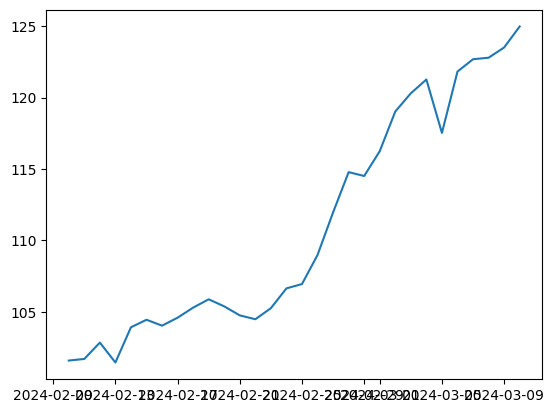

In [56]:
import matplotlib.pyplot as plt 
results_df.head()

# plt.figure(figsize=(14, 7))
plt.plot(results_df["timestamp"], results_df["principal"])

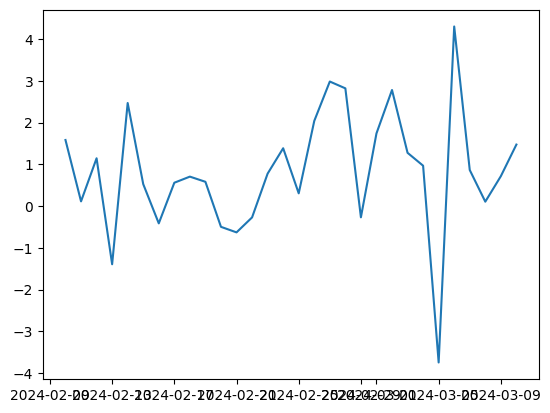

In [57]:
plt.plot(results_df["timestamp"], results_df["return"])


In [40]:
results_df["return"].describe()

count    30.000000
mean      0.329906
std       1.391608
min      -3.838690
25%      -0.361961
50%       0.273807
75%       1.074369
max       3.398680
Name: return, dtype: float64